In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../')
from galaxybrain.ramsey import pca, fooofy
from galaxybrain.plot_utils import rc_style, pltlabel, colorcycler, solo_colorbar
rc_style()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from neurodsp.sim import sim_powerlaw
from neurodsp.spectral import compute_spectrum

COLORS = ['#111d6c', '#e03694']

# Fractional Brownian motion (fBm) simulation

simulated using [`neurodsp.sim.sim_powerlaw`](https://neurodsp-tools.github.io/neurodsp/generated/neurodsp.sim.sim_powerlaw.html#neurodsp.sim.sim_powerlaw)
```python
Signature: sim_powerlaw(n_seconds, fs, exponent=-2.0, f_range=None, **filter_kwargs)
Docstring:
```
```
Simulate a power law time series, with a specified exponent.

Parameters
----------
n_seconds : float
    Simulation time, in seconds.
fs : float
    Sampling rate of simulated signal, in Hz.
exponent : float
    Desired power-law exponent, of the form P(f)=f^exponent.
f_range : list of [float, float] or None, optional
    Frequency range to filter simulated data, as [f_lo, f_hi], in Hz.
**filter_kwargs : kwargs, optional
    Keyword arguments to pass to `filter_signal`.

Returns
-------
sig: 1d array
    Time-series with the desired power law exponent.
```

## Effect of increasing fractal dimension ($\alpha$) on signal dynamics

$\alpha = 2H + 1$, where $H$ is the hurst exponent

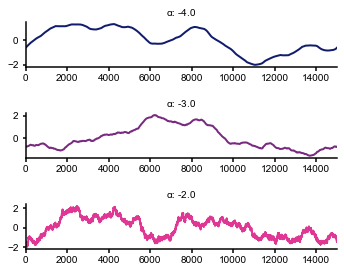

In [3]:
plt.figure(figsize=(5,4))
T, FS = 30, 500
sample_exps = np.linspace(-4, -2, 3)
colors = colorcycler(COLORS, len(sample_exps), False)
for n_i, a in enumerate(sample_exps):
    signal = sim_powerlaw(n_seconds=T, fs=FS, exponent=a)
    plt.subplot(3,1,n_i+1)
    plt.plot(signal, color=colors[n_i])
    plt.xlim([0, T*FS])
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title(r'$\alpha$: {}'.format(a), fontsize=10)
plt.tight_layout()
# plt.savefig('../fig/fbm/ts_samples.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Multiple fBm signals are not correlated

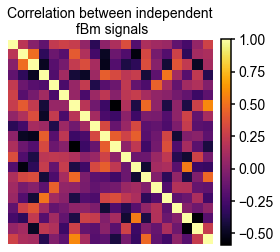

In [41]:
exp, num = -3, 20
signals = []
for i in enumerate(range(num)):
    signals.append(sim_powerlaw(n_seconds=30, fs=500, f_range=[0.1,100], exponent=exp))

correlations = np.corrcoef(np.array(signals))

plt.figure()
plt.imshow(correlations, 'inferno')
plt.colorbar(fraction=0.046, pad=0.04)
pltlabel('Correlation between independent\n fBm signals')
plt.axis('off')
plt.show()
# plt.savefig('../fig/fbm/corr_mat.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Calculate fBm spatial & temporal spectra over exponent range

In [5]:
def sim_and_fit(exponents, sum_sig, num=100, f_range=None):
    """
    Iterates over list of exponents, simulates an fBm signal
    and calculate spatial & temporal spectra, and fits exponent
    returns:
        slopes: [(espec exp, psd exp)...]
        pca_results: evals
        fft_results: spectrum
    """
    FS=500
    nperseg=FS
    noverlap=FS/2 #; freqs = np.fft.rfftfreq(nperseg); 
    pc_dims = np.arange(1,num+1)
    pca_results = []
    fft_results = []
    slopes = []
    for exp in exponents:
        sig = np.array([sim_powerlaw(60, FS, exp) for n in range(num)]) # sample of num signals
        evals = pca(sig.T, num) # transpose shape
        pca_results.append(evals)
        
        if sum_sig:
            sig = np.array(sig).sum(axis = 0) # now one time series
        freqs, spec = compute_spectrum(sig, FS, nperseg=nperseg, noverlap=noverlap)
        fft_results.append(spec)
        if not sum_sig:
            spec = spec.mean(0)
        slopes.append( (fooofy(pc_dims, evals, None, group = False)['exponent'], 
                        fooofy(freqs, spec, f_range, group = False)['exponent']) )
            # returning np.arrays for np methods
    return tuple(map(np.array, (slopes, pca_results, fft_results)))

exponents = np.around(np.arange(-4,0.2,0.2),1) #no sci notation
slopes, pca_results, fft_results = sim_and_fit(exponents, sum_sig = False)
slopes_sum, pca_results_sum, fft_results_sum = sim_and_fit(exponents, sum_sig = True)

In [13]:
sim_powerlaw(60, 500, 0).shape

(30000,)

# note: the higher exponents are actually kind of bent in ES, and mostly flat in PSD

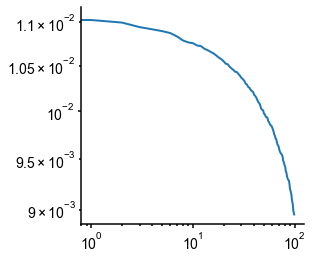

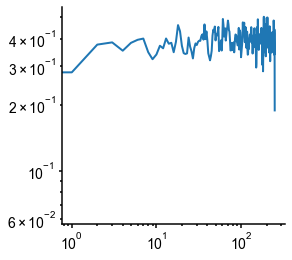

In [6]:
plt.loglog(pca_results_sum[-1])
plt.show()
plt.loglog(fft_results_sum[-1])
plt.show()


In [12]:
fft_results_sum.shape

(21, 251)

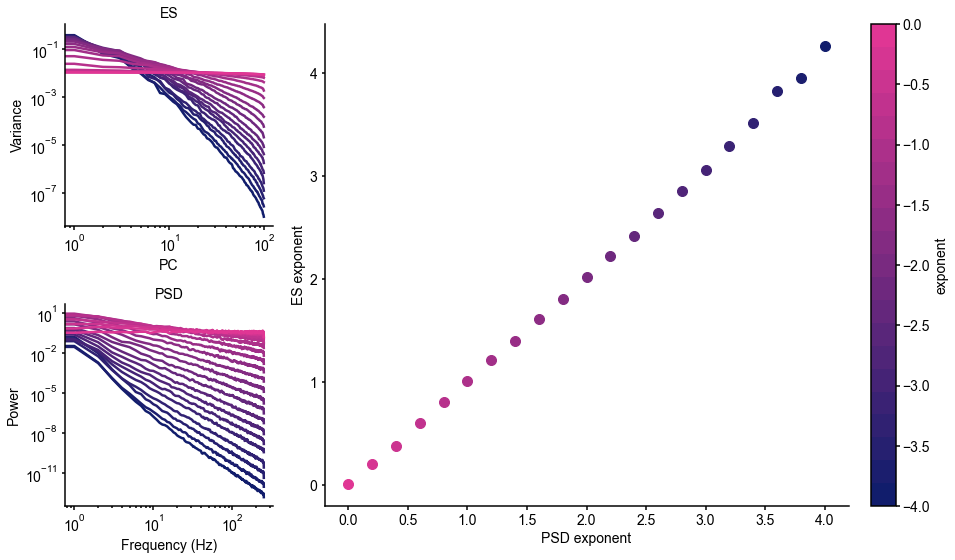

In [16]:
fig = plt.figure(figsize=(13.5,8))
gs = GridSpec(2,2, width_ratios=[1, 2.75])


colorcycler(COLORS, exponents.shape[0])
# e spec
for (i, data), labels in\
        zip(enumerate([pca_results_sum,         fft_results_sum]), 
                     [['ES', 'PC', 'Variance'], ['PSD','Frequency (Hz)', 'Power']]):
    ax = fig.add_subplot(gs[i, 0])

    plt.loglog(data.T, linewidth=2.5) 
    pltlabel(*labels)
    
ax = fig.add_subplot(gs[:,1])
colors = colorcycler(COLORS, exponents.shape[0], False)

positive_exps = [-1*i for i in exponents] # make sign of number consistent across axes
for x,y in zip(positive_exps, slopes_sum.T[1]):
    ax.scatter(x, y, s=100)
pltlabel('', 'PSD exponent', 'ES exponent') 
solo_colorbar(COLORS, exponents, 'exponent')

plt.tight_layout()   

plt.savefig('../fig/fbm/spectra_corr.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Universality class comparison: psd-espec relationship in ising vs fbm vs mouse
- with mice might have to fix a subsample size to get enough unique time series (also assuming it's a mutant tri-headed mouse)
- by simulating multiple series, essentially it's like subsampling but at 100% each time
- theoretically: how to create a dynamical system that, as you tweak the PSD, how does ES change?

In [19]:
from galaxybrain.ising import metro_ising, T_CRIT

In [47]:
temps = np.sort(np.append(np.linspace(0.01, 5, 20), T_CRIT))


def multi_signal_exponents_ising(temps = None,num = 100,FS=1,nperseg=2000,noverlap=int(.8*2000)):
    
    pca_results = []
    pc_dims = np.arange(1,num+1)

    espec_exp = []
    psd_exp = []

    for temp in temps[3:]:
        signals = []
        for i in range(num):
            tensor  = metro_ising(N=16, T=temp, runtime=10000)
            signals.append(tensor.sum(axis=-1).sum(axis=-1))

        signals = np.array(signals)

        # compute PCA
        evals = pca(signals.T, num) # transpose shape
        pca_results.append(evals)


        # compute FT
        sum_sig = np.array(signals).sum(axis = 0) # now one time series
        freqs, spec = compute_spectrum(sum_sig, FS, nperseg=nperseg, noverlap=noverlap)

        #fit
        psd_exp.append(fooofy(freqs, spec, None, group=False)['exponent'])
        espec_exp.append(fooofy(pc_dims, evals, None, group=False)['exponent'])
        
    return psd_exp, espec_exp
    

# include mouse points on this plot

normalizing neuron population size?


In [53]:
mouse2022[mouse]['all']['data']['psd_exponent1'][0][-1]

0.8958902801747624

{'n_iter': 95, 'n_pc': 0.8, 'pc_range': [0, None], 'f_range': [0, 0.4], 'ft_kwargs': {'fs': 1, 'nperseg': 120, 'noverlap': 60.0}}


Text(0, 0.5, 'ES exp')

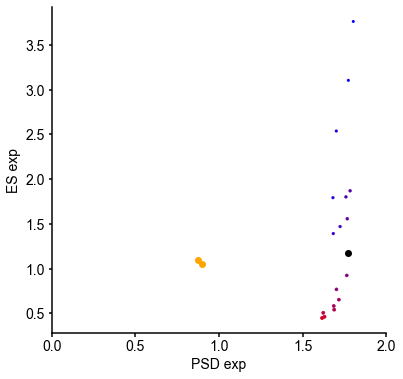

In [59]:
from galaxybrain.plot_utils import rc_style, pltlabel, plot_ising_spectra, measure_over_temps, TEMP_COLOR_RANGE, colorcycler, noticks

# MICE
from galaxybrain.data_utils import load_results, MouseData, ALL_REGIONS
mouse2022 = load_results('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/experiments/exp_mouse')

mice_es_x = []
mice_psd_x = []
for mouse in ['krebs', 'robbins']:
    mice_es_x.append(mouse2022[mouse]['all']['data']['es_exponent'][0][-1])
    mice_psd_x.append(mouse2022[mouse]['all']['data']['psd_exponent1'][0][-1])

COLORS = colorcycler(['blue', 'red'], len(temps), default=False)
lws = {T_CRIT:4}
cs = {T_CRIT:'k'}

plt.figure(figsize=(6,6))
for px, ex, c, t  in zip(psd_exp, espec_exp, COLORS, temps):
    plt.scatter(px, ex, color=cs.get(t,c), lw=lws.get(t,c))
    
for px, ex in zip(mice_psd_x, mice_es_x):
    plt.scatter(px, ex, color='orange', lw=4)
    
plt.xlim([0,2])
plt.xlabel('PSD exp')
plt.ylabel('ES exp')

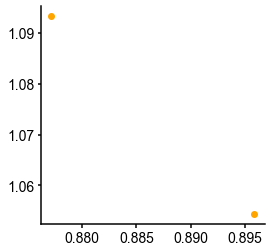

In [56]:
for px, ex in zip(mice_psd_x, mice_es_x):
    plt.scatter(px, ex, color='orange', lw=4)